# Segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neptune
neptune.set_project('dalessioluca/neurons')
exp = neptune.create_experiment(name='5_neurons_exploration')    

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/neurons/e/NEUR-11


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy 
import torch
import skimage.filters
from util_luca import *

device = torch.device("cpu")
dtype = torch.float32

### Paths

In [4]:
data_dir = '/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/'
file_list = next(iter(os.walk(data_dir)))[2]

print(data_dir)
print(file_list)

/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/
['noisy_movie_tyx.npy', 'clean_fluorescence_tyx.npy', 'neuron_mean_fluorescence_nt.npy', 'background_tyx.npy', 'soma_coords_n2.npy', 'clean_movie_tyx.npy', 'masks_nyx.npy']


## Load the clean movie and the mask

In [5]:
soma_coords_n2 = numpy.load(os.path.join(data_dir,"soma_coords_n2.npy"))
#noisy_movie_tyx = numpy.load(os.path.join(data_dir,"noisy_movie_tyx.npy"))
clean_movie_tyx = numpy.load(os.path.join(data_dir,"clean_movie_tyx.npy"))
masks_nyx = numpy.load(os.path.join(data_dir,"masks_nyx.npy"))
#background_tyx = numpy.load(os.path.join(data_dir,"background_tyx.npy"))
#clean_fluorescence_tyx = numpy.load(os.path.join(data_dir,"clean_fluorescence_tyx.npy"))
neuron_mean_fluorescence_nt = numpy.load(os.path.join(data_dir,"neuron_mean_fluorescence_nt.npy"))

### Basic Inspection

In [6]:
print(type(clean_movie_tyx), clean_movie_tyx.shape, clean_movie_tyx.dtype)
print(type(masks_nyx), masks_nyx.shape, masks_nyx.dtype)
print(type(soma_coords_n2), soma_coords_n2.shape, soma_coords_n2.dtype)
print(type(neuron_mean_fluorescence_nt), neuron_mean_fluorescence_nt.shape, neuron_mean_fluorescence_nt.dtype)

<class 'numpy.ndarray'> (3000, 180, 512) float64
<class 'numpy.ndarray'> (5, 180, 512) bool
<class 'numpy.ndarray'> (5, 2) int64
<class 'numpy.ndarray'> (5, 3000) float64


### Analyze the movie intensity over time and extract the breakpoints

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


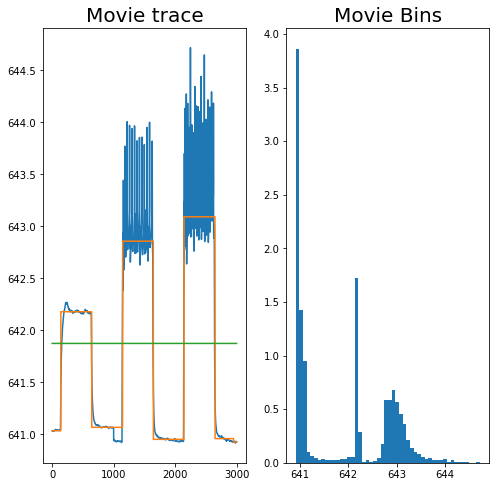

In [7]:
#!pip install mlinsights
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

movie_trace = numpy.mean(clean_movie_tyx, axis=(-1,-2))
movie_trace_thresh = skimage.filters.threshold_otsu(movie_trace.reshape(-1))

pad_width = 1000
movie_trace_padded = numpy.pad(movie_trace, pad_width=pad_width, mode='edge') 
X_train_padded = numpy.arange(movie_trace_padded.shape[0]).reshape(-1,1)-pad_width

# Fit the padded model
model = PiecewiseRegressor(verbose=True,
                           binner=DecisionTreeRegressor(criterion='mse', min_samples_leaf=300),
                           estimator=DummyRegressor(constant=None, quantile=None, strategy='median'))
model.fit(X_train_padded, movie_trace_padded)

# Predict the NON-padded model
pred = model.predict(numpy.arange(movie_trace.shape[0]).reshape(-1,1))

fontsize=20
fig, ax = plt.subplots(ncols=2, figsize=(8,8))
ax[0].set_title("Movie trace", fontsize=fontsize)
ax[0].plot(movie_trace)
ax[0].plot(pred)
ax[0].plot(movie_trace_thresh*numpy.ones_like(movie_trace))
ax[1].set_title("Movie Bins", fontsize=fontsize)
_ = ax[1].hist(movie_trace, density=True, bins=50)

### Extract the breakpoints

In [8]:
pred_gt_threshold = (pred > movie_trace_thresh)
pred_gt_threshold_shifted = numpy.roll(pred_gt_threshold,-1,axis=0)

bp_mask = (pred_gt_threshold != pred_gt_threshold_shifted)
bp_mask[0]=True
bp_mask[-1]=True
bp = numpy.arange(pred.shape[0])[bp_mask]
for i in range(len(bp)-1):
    i_left = bp[i]
    i_right = bp[i+1]
    i_middle = int((i_left+i_right)*0.5) 
    gt = pred_gt_threshold[i_middle]
    print(i_left, i_right, gt)

0 139 False
139 642 True
642 1144 False
1144 1644 True
1644 2141 False
2141 2647 True
2647 2999 False


# ANALYZE ONE INTERVAL AT THE TIME

In [9]:
t_start, t_end = 2141, 2647

## GROUND TRUTH INFORMATION

### Visualize the Neurons Mask

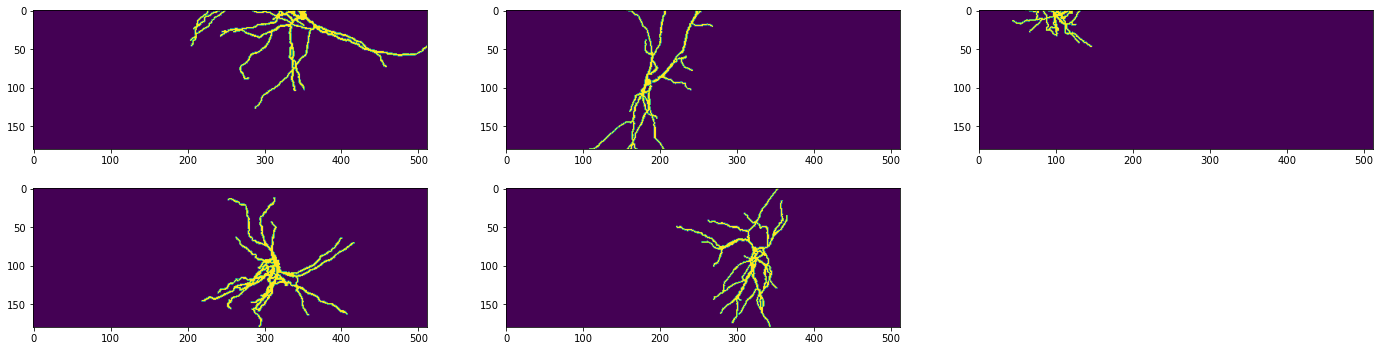

In [10]:
fig = visualize_image_list(images=[masks_nyx[i] for i in range(masks_nyx.shape[0])])
exp.log_image("gt_masks", fig)
fig

### Visualize the Neurons Traces

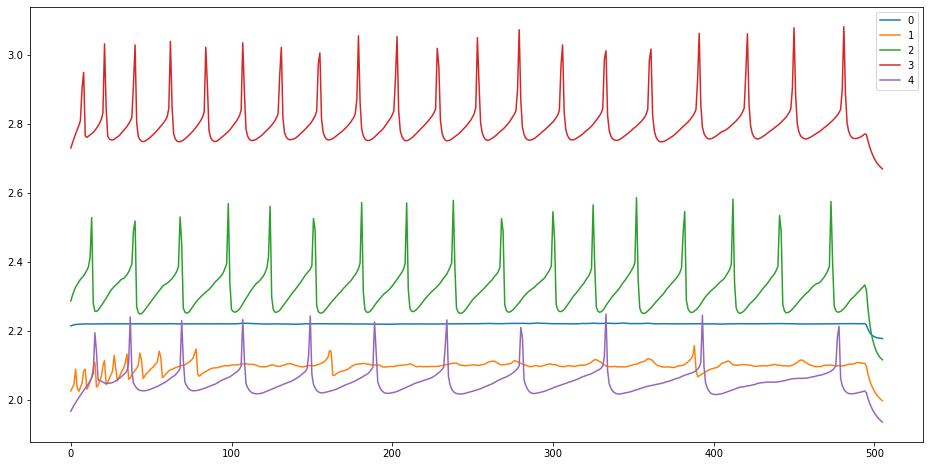

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
for n in range(neuron_mean_fluorescence_nt.shape[0]):
    cy, cx = soma_coords_n2[n,1], soma_coords_n2[n,0]
    ax.plot(neuron_mean_fluorescence_nt[n,t_start:t_end], label=str(n))
plt.legend()
plt.close(fig)
exp.log_image("traces_gt.png", fig)
fig   

# BASIC INSPECTION  

### Movie traces in each segment

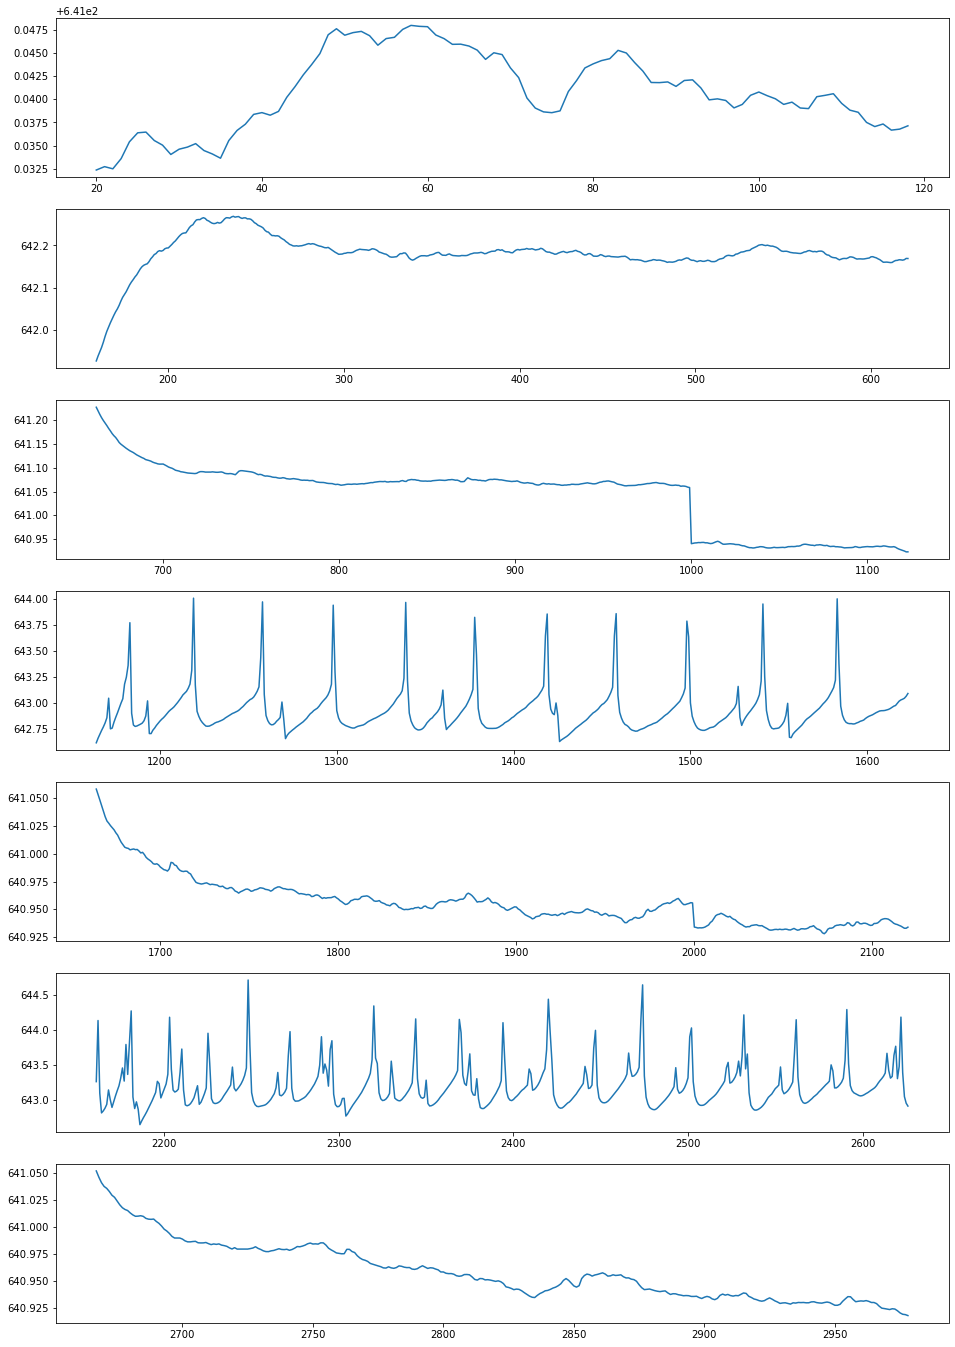

In [12]:
N_interval=bp.shape[0]-1
avoid_region_near_bp = 20

fontsize=20
fig, ax = plt.subplots(nrows=N_interval, figsize=(16,24))
for n in range(N_interval):
    i_left = bp[n]+avoid_region_near_bp
    i_right = bp[n+1]-avoid_region_near_bp
    x = numpy.arange(i_left,i_right)
    ax[n].plot(x, movie_trace[i_left:i_right])

### Extract the foreground mask
For each pixel compute the maximum (actually the 90% percentile) and do Otsu

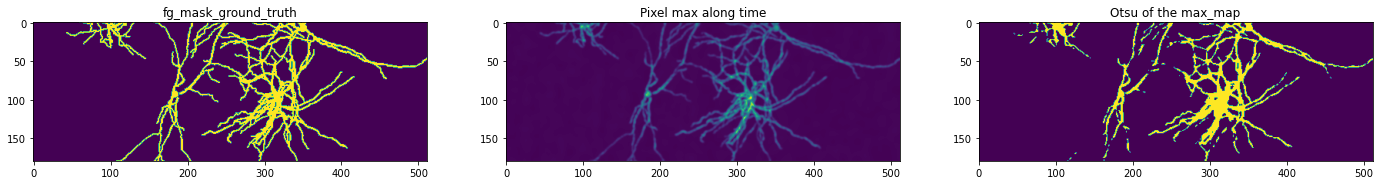

In [13]:
fg_mask_ground_truth = numpy.max(masks_nyx, axis=0)
maxmap = numpy.max(clean_movie_tyx, axis=0)
fg_thresh = skimage.filters.threshold_otsu(maxmap.reshape(-1))

fig, ax = plt.subplots(ncols=3, figsize=(24,6))
ax[0].set_title("fg_mask_ground_truth")
ax[0].imshow(fg_mask_ground_truth)
ax[1].set_title("Pixel max along time")
ax[1].imshow(maxmap)
ax[2].set_title("Otsu of the max_map")
ax[2].imshow(maxmap > fg_thresh)
exp.log_image("foreground_mask", fig)

# DETREND THE MOVIES IN DIFFERENT WAYS

In [14]:
t_start, t_end = 2141, 2647

# Here I am doing a long time calculation
pixel_mean = numpy.mean(clean_movie_tyx[t_start:t_end], axis=-3, keepdims=True)
pixel_std = numpy.std(clean_movie_tyx[t_start:t_end], axis=-3, keepdims=True)
detrended0 = clean_movie_tyx[t_start:t_end] - pixel_mean
detrended1 = detrended0 / pixel_std
detrended2 = detrended1/ numpy.sqrt(numpy.sum(detrended1*detrended1, axis=-3, keepdims=True))
detrended3 = detrended0 / numpy.sqrt(numpy.sum(detrended0*detrended0, axis=-3, keepdims=True))

# Here I am using a small averaging window
mu_tyx, std_tyx = mu_std_moving_average(clean_movie_tyx[t_start:t_end], axis=0, window_type='center', window_size=11)
detrended4 = clean_movie_tyx[t_start:t_end]-mu_tyx
detrended5 = detrended4 / std_tyx
detrended6 = detrended5/ numpy.sqrt(numpy.sum(detrended5*detrended5, axis=-3, keepdims=True))
detrended7 = detrended4/ numpy.sqrt(numpy.sum(detrended4*detrended4, axis=-3, keepdims=True))

detrended_movies = [detrended0, detrended1, detrended2, detrended3, 
                    detrended4, detrended5, detrended6, detrended7]

In [21]:
numpy.savez("detrended.npz", detrended_movies=detrended_movies)



In [22]:
npzfile = numpy.load("detrended.npz")

In [24]:
movies = npzfile["detrended_movies"]

In [25]:
len(movies)

8

### Visualize the detrended strategies close to one neuron center

In [ ]:
for n in range(soma_coords_n2.shape[0]):
    fig = show_traces_from_movie(c_yx=soma_coords_n2[n], 
                                 shifts=(0,5,10,40), 
                                 movies=detrended_movies, 
                                 title="detrending strategies for neuron "+str(n))
    exp.log_image("traces_detrended.png", fig)
fig

In [ ]:
for shift in [0, 5, 10, 40]:
    for n in range(masks_nyx.shape[0]):
        gt_mask = masks_nyx[n]
        c_yx = soma_coords_n2[n]+numpy.array([shift,shift])
        correlation_maps = compute_correlation_maps(c_yx, movies=detrended_movies)
        title = "neuron_"+str(n)+"__shift_"+str(shift)
        fig = plot_correlation_maps(c_yx, gt_mask, correlation_maps, title=title)
        exp.log_image("correlation_shift"+str(shift), fig)
fig